# Notebook to address issues with Drosophila spike detection

The spike threshold seems way off, but this may not be the only issue

## Imports

In [1]:
import os 
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

from mosquito.util import idx_by_thresh, butter_highpass_filter, butter_bandpass_filter
from mosquito.process_abf import load_processed_data, detrend_emg

## Params

In [2]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


## Load data

In [4]:
# load processed data
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '36_20240702'  # '28_20240529'  #  '17_20240507'
axo_num = 5
# vid_str = 'aedes_C001H001S0001_20240326_154951'
data = load_processed_data(data_folder, axo_num)

In [24]:
# read data into memory
t = data['time']  
emg_filt = data['emg_filt']
emg = data['emg']
spike_idx = data['spike_idx']

window = 2*data['params']['emg_window']
fs = data['sampling_freq']

In [25]:
spike_idx

array([    521,    7617,    9527, ..., 5352496, 5353859, 5354571])

Text(0.5, 0, 'time (s)')

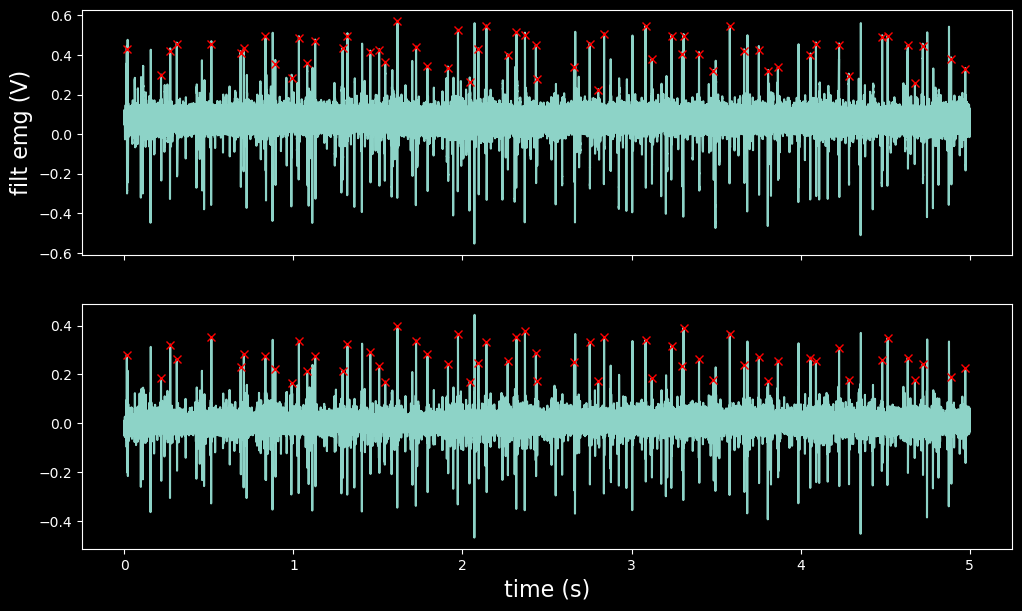

In [26]:
# plot filtered emg data
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(12,7),sharex=True)


tmin = 0 # 5
tmax = 5
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)

ax0.plot(t[mask], emg[mask])
ax0.plot(t[spike_idx][mask_spikes], emg[spike_idx][mask_spikes], 'rx')
ax0.set_ylabel('emg (V)')

ax1.plot(t[mask], emg_filt[mask])
ax1.plot(t[spike_idx][mask_spikes], emg_filt[spike_idx][mask_spikes], 'rx')
ax0.set_ylabel('filt emg (V)')

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_xlabel('time (s)')

## Try another pass at filtering data

In [27]:
# set new bandpass levels
lowcut = 10
highcut = 10000

emg_filt_new = butter_bandpass_filter(emg, lowcut, highcut, (1/fs))


In [28]:
# # try an additional bandstop?
# lowcut = 140
# highcut = 200
# emg_filt_new2 = butter_bandpass_filter(emg_filt_new, lowcut, highcut, (1/fs), btype='bandstop')

In [29]:
# try detrending data
emg_filt_new2 = detrend_emg(emg_filt_new, window=1028)


Text(0.5, 0, 'time (s)')

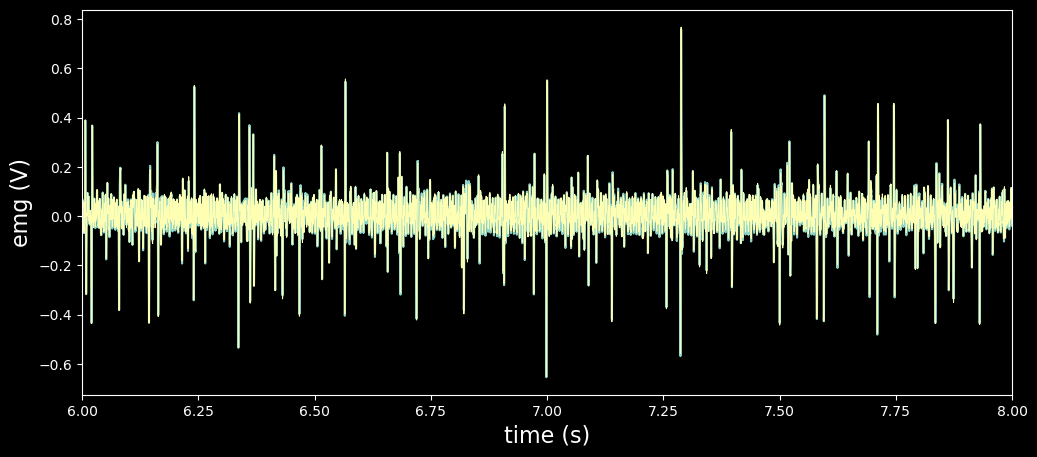

In [30]:
# compare
fig, ax = plt.subplots(figsize=(12,5))


tmin = 6 # 5
tmax = 8
mask = (t >= tmin) & (t <= tmax)

ax.plot(t[mask], emg_filt_new[mask])
# ax.plot(t[mask], emg[mask], lw=0.75)
ax.plot(t[mask], emg_filt_new2[mask], lw=0.75)

ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')

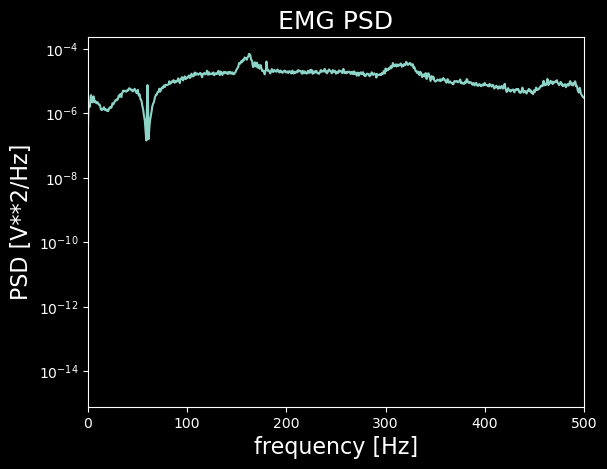

In [31]:
# check out emg PSD
nperseg = 4*16384  # 1028
f, Pxx_den = signal.welch(emg_filt_new2, fs, nperseg=nperseg)

fig, ax = plt.subplots()
ax.semilogy(f, Pxx_den)
# plt.ylim([0.5e-3, 1])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_title('EMG PSD')
ax.set_xlim([0, 500])
plt.show()

## Try same procedure as used in code

In [32]:
# get thresh
mad = np.median(np.abs(emg_filt - np.median(emg_filt)))
thresh_factors = (1,8)
min_spike_dt = 0.0015

# threshold is calculated by finding ~5 sigma level (sd approximated by MAD)
thresh = 5 * mad / 0.6745  # 0.6745 is the factor relating median absolute deviation to sd
min_peak_dist = np.round(fs*min_spike_dt)
min_height = thresh_factors[0] * thresh  # 2*
max_height = thresh_factors[1] * thresh  # 8*

In [33]:
# get peaks
peak_signal = emg_filt.copy()
peak_signal = np.abs(peak_signal)

peaks, _ = signal.find_peaks(peak_signal,
                                 height=(min_height, max_height),
                                 distance=min_peak_dist)

(0.0, 5.0)

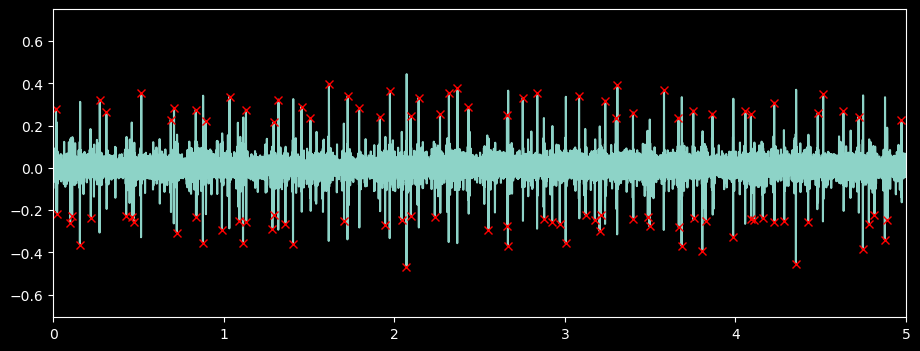

In [34]:
# visualize
fig, ax = plt.subplots(figsize=(11,4))

ax.plot(t, emg_filt)
ax.plot(t[peaks], emg_filt[peaks], 'rx')

ax.set_xlim([0, 5])

In [38]:
# extract window around detected peaks (+/- spike window)
n_pts = emg.size
spike_list = []
peaks_new = []
offset = 8 

# loop over detected peaks
for pk in peaks:
    # get range around current peak
    if (pk - window) < 0 or (pk + window) > n_pts:
        continue
    spike_ind_init = range(pk - int(window/4), pk + int(window/4))

    # recenter to max value
    pk_new = spike_ind_init[np.argmin(emg[spike_ind_init])]
    if (pk_new == spike_ind_init[0]) or (pk_new == spike_ind_init[-1]):
        # if our recentering takes us to the edge of the window, we're probably not on a peak
        continue
    spike_ind = range(pk_new - window + offset, pk_new + window + offset)
    if (spike_ind[0] < 0) or (spike_ind[-1] >= n_pts):
        # if we're on the edge of the time series, skip
        continue
    spike_waveform = emg_filt[spike_ind]

    # get new window/peak location (but first check if we already have this spike)
    if pk_new not in peaks_new:
        peaks_new.append(pk_new)
        spike_list.append(spike_waveform)


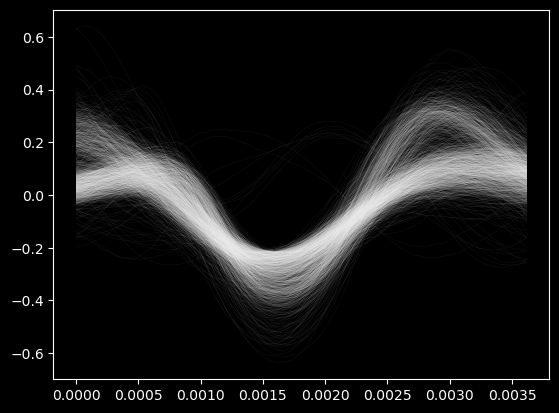

In [39]:
# visualize
fig, ax = plt.subplots()
spike_t = (1/fs)*np.arange(spike_list[0].size)

for spike in spike_list:
    ax.plot(spike_t, spike, 'w-', lw=0.25, alpha=0.1)